### Autoencoder : Only dense layers
### Classifier :  
                   1. Only Dense layers  
                   2. CNN 1D 
### No augmentation, no joint training

### Observation:
1. Tried to fit MLP as well as CNN-1D classifier using features extracted from MLP autoencoder 
2. In order to get idea of classification performance, did not use augmentation or joint training.
3. FC and 1d-CNN classifier training resulted in extreme overfitting. Training accuracy of about 96% and validation around 50% and 44% respectively.
4. The network does not seem to learn the generalized features. With such a big different, reducing network parameters to reduce overfitting or add regularization does not promise accuracy to jump high. So adding augmentation or joint training does not seem worth trying since the network is not at all able to generalize on the features from MLP autoencoder.


In [10]:
%matplotlib inline
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Conv1D, Conv2D, Activation, BatchNormalization,\
                         Flatten, Dense, Conv2DTranspose, Reshape,MaxPooling2D, \
                         UpSampling2D, Lambda, Dropout, Concatenate
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import l1,l2
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pickle
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns

tf.set_random_seed(11)
random.seed(11)
data_path = "cifar-10-batches-py"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"  

# *Read Data*

In [11]:
def unpickle(file):
    with open(file, 'rb') as fo:
        datadict = pickle.load(fo, encoding='bytes')
    return datadict

In [12]:
label_path = os.path.join(data_path,'batches.meta')
label_dict = unpickle(label_path) 
class_list_b = label_dict[b'label_names']
cut_factor = 0.5
bird = 2
deer = 4
truck = 9
downsample_list = [2,4,9]
class_list=[]
for each in class_list_b:
    class_list.append(each.decode('utf8'))

In [13]:
def load_train_data(data_path):
    for i in range(1,6):
        batch_path = os.path.join(data_path, 'data_batch_' + str(i))
        data_dict = unpickle(batch_path)
        #d =collections.Counter(data_dict[b'labels'])
        #dd = collections.OrderedDict(sorted(d.items(), key=lambda t: t[0]))
        #print(d)
        #print(dd)
        if (i == 1):
            train_data = data_dict[b'data']
            train_labels = data_dict[b'labels']
            
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
            train_labels += data_dict[b'labels']
    
    
    train_data = train_data.reshape((len(train_data),3,32, 32))
    train_data = train_data.transpose(0, 2, 3, 1)
    train_labels = np.asarray(train_labels)
    
    data_dict = unpickle(data_path+"/test_batch")
    test_data = np.asarray(data_dict[b'data'])
    test_labels = np.asarray(data_dict[b'labels'])
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = test_data.transpose(0, 2, 3, 1)
    return train_data,train_labels,test_data,test_labels

def downsample_data(downsample_list,Xtrain,Ytrain,cut_factor):
    for i,class_id in enumerate(downsample_list):
        label_idx = [idx for idx, y in enumerate(Ytrain) if y == class_id]
        if (i == 0):
            downsample_ids = random.sample(label_idx,(int)(cut_factor*len(label_idx)))
        else:
            downsample_ids += random.sample(label_idx,(int)(cut_factor*len(label_idx)))
    downsample_ids = sorted(downsample_ids)
    new_Xtrain = np.delete(Xtrain,downsample_ids,axis=0)
    new_Ytrain = np.delete(Ytrain,downsample_ids,axis=0)
    return new_Xtrain,new_Ytrain    

full_Xtrain,full_Ytrain,Xtest,Ytest = load_train_data(data_path)
Xtrain,Ytrain = downsample_data(downsample_list,full_Xtrain,full_Ytrain,cut_factor)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

class_weights = list(class_weight.compute_class_weight(
               'balanced',
                np.unique(Ytrain), 
                Ytrain.reshape(Ytrain.shape[0])))
print(class_weights)

#d =collections.Counter(new_Ytrain)
#print(collections.OrderedDict(sorted(d.items(), key=lambda t: t[0])))
num_training_imgs = Xtrain.shape[0]
num_test_imgs = Xtest.shape[0]
num_classes = len(np.unique(Ytrain))

print(num_classes,num_training_imgs,num_test_imgs)

Xtrain = Xtrain.astype('float32') / 255.
Xtest = Xtest.astype('float32') / 255.
YtrainHot = keras.utils.to_categorical(Ytrain, num_classes)
YtestHot = keras.utils.to_categorical(Ytest, num_classes)

# Xtrain_mean = np.mean(Xtrain, axis=0)
# Xtrain -= Xtrain_mean
# Xtest -= Xtrain_mean

#standardization
# Xtrain_mean = np.mean(Xtrain,axis=(0,1,2))
# std = np.std(Xtrain,axis=(0,1,2))
# Xtrain = Xtrain/(std+1e-7)
# Xtest = Xtest/(std+1e-7)
# print(Xtrain_mean)
# print(std)

# logdir = "logs/"
# tboard_callback = TensorBoard(log_dir=logdir)
num_classes = 10

(42500, 32, 32, 3)
(42500,)
(10000, 32, 32, 3)
(10000,)
[0.85, 0.85, 1.7, 0.85, 1.7, 0.85, 0.85, 0.85, 0.85, 1.7]
10 42500 10000


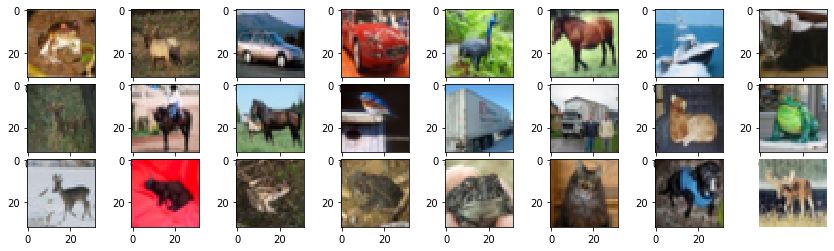

In [14]:
def check_images(images):
    fig = plt.figure(figsize=(15, 4))
    columns = 8
    rows = 3
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    
    fig.subplots_adjust(hspace=0.1)
    fig.subplots_adjust(wspace=0)
    plt.axis('off')
    #plt.tight_layout()
    plt.show()
    
check_images(Xtrain)

# Utility functions

In [15]:
def visualize_reconstruction(ip, dec, num=10):
    n = num
    plt.figure(figsize=(20, 4))
    mse = np.mean(((ip.astype("float") - dec.astype("float"))**2),axis=(0,1,2,3))
    print(mse)   
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(ip[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def evaluate_classification(Ytest,Ypred):
    cm=confusion_matrix(Ytest, Ypred)
    print("Classification Report:\n")
    cr=classification_report(Ytest,Ypred,target_names=class_list)
    print(cr)
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels = class_list, yticklabels = class_list, fmt="d")

In [16]:
def ae_model():
    
    input_img = Input(shape=(32,32,3))  
    x = Flatten()(input_img)   #3072
    x = BatchNormalization()(x)
    x = Dense(1536, activation='relu', name='encoder')(x)  
    x = Dense(768, activation='relu', name='features')(x)
    x = BatchNormalization(name='bn_feats')(x)
    x = Dense(1536, activation='relu', name='decoder')(x)
    x = Dense(3072, activation='sigmoid', name='recon')(x)
    out = Reshape((32,32,3))(x)
    model = Model(inputs=input_img, outputs=out)

    return model


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 42500 samples, validate on 10000 samples
Epoch 1/100
42500/42500 [==============================] - 6s 151us/sample - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 2/100
42500/42500 [==============================] - 5s 127us/sample - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 3/100
42500/42500 [==============================] - 6s 130us/sample - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 4/100
42500/42500 [==============================] - 5s 126us/sample - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 5/100
42500/42500 [==============================] - 5s 123us/sample - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0075 - val_mean

Epoch 94/100
42500/42500 [==============================] - 5s 124us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 95/100
42500/42500 [==============================] - 5s 121us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 96/100
42500/42500 [==============================] - 5s 128us/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 97/100
42500/42500 [==============================] - 5s 126us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 98/100
42500/42500 [==============================] - 5s 123us/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 99/100
42500/42500 [==============================] - 5s 126us/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0018 -

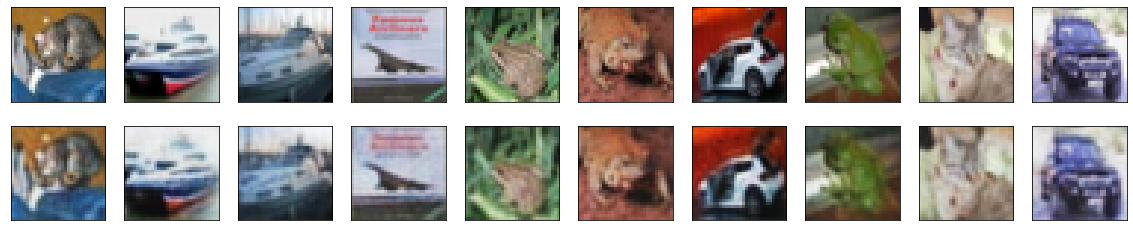

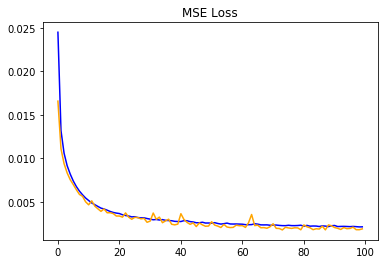

In [8]:
ae_model = ae_model()
opt = Adam(lr=0.0001) 
ae_model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mean_squared_error'])

history = ae_model.fit(Xtrain,Xtrain,
           validation_data=(Xtest,Xtest),
           batch_size=128,
           epochs=100,
           shuffle=True)

encoder_model = Model(inputs=ae_model.input,
                                 outputs=ae_model.get_layer('features').output)

pred_imgs = ae_model.predict(Xtest)
visualize_reconstruction(Xtest,pred_imgs)


plt.title('MSE Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()


# *Autoencoder: features - tsne*

(999, 768)


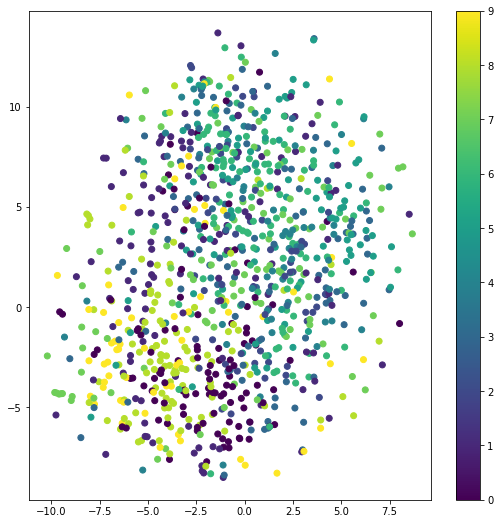

In [9]:
enc_train_features = encoder_model.predict(Xtrain[1:1000,...])
print(enc_train_features.shape)
tsne = TSNE().fit_transform(enc_train_features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

plt.figure(figsize=(9, 9))
plt.scatter(tsne[:, 0], tsne[:, 1], c=Ytrain[1:1000])
plt.colorbar()
plt.show()


In [53]:
def classification_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=768))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    return model


In [45]:
bn_encoder_model = Model(inputs=ae_model.input,
                                 outputs=ae_model.get_layer('bn_feats').output)

cmodel = classification_model()
#opt = SGD(lr=0.0005, momentum=0.9)
opt = Adam(lr = 0.001)
cmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
           

train_datagen = ImageDataGenerator(shear_range=0.2, rotation_range=20, zoom_range=0.2, brightness_range=[0.3,0.7],
                                   width_shift_range=0.1, height_shift_range=0.2, horizontal_flip=True,
                                   vertical_flip=True, fill_mode="nearest")

test_datagen = ImageDataGenerator() 
              
def data_generator(train_datagen,Xtrain,YtrainHot,batchsize):
    train_gen = train_datagen.flow(Xtrain, YtrainHot, batch_size=batchsize)
    while(True):
        Xtrain_data, Ytrain_data = train_gen.next()
        Xtrain_features = bn_encoder_model.predict(Xtrain_data)
        yield(Xtrain_features, Ytrain_data)
        
Xtrain_features = encoder_model.predict(Xtrain)
Xtest_features = encoder_model.predict(Xtest)
bn_Xtrain_features = bn_encoder_model.predict(Xtrain)
bn_Xtest_features = bn_encoder_model.predict(Xtest)


history_c = cmodel.fit(bn_Xtrain_features,
           YtrainHot,
           validation_data=(bn_Xtest_features, YtestHot),
           batch_size=128,
           epochs=200,
           shuffle=True)
              
# steps = int(Xtrain.shape[0] / 128)              
# history_c = cmodel.fit_generator(
#         data_generator(train_datagen,Xtrain,YtrainHot,128),
#         steps_per_epoch=steps,
#         epochs=350,
#         shuffle=True,
#         validation_data=data_generator(test_datagen,Xtest,YtestHot,128),
#         validation_steps=Xtest.shape[0]//128)


Train on 42500 samples, validate on 10000 samples
Epoch 1/200
42500/42500 [==============================] - 1s 20us/sample - loss: 1.7340 - acc: 0.3992 - val_loss: 1.5456 - val_acc: 0.4487
Epoch 2/200
42500/42500 [==============================] - 1s 13us/sample - loss: 1.4572 - acc: 0.4891 - val_loss: 1.4713 - val_acc: 0.4752
Epoch 3/200
42500/42500 [==============================] - 1s 13us/sample - loss: 1.3448 - acc: 0.5261 - val_loss: 1.4119 - val_acc: 0.4981
Epoch 4/200
42500/42500 [==============================] - 1s 13us/sample - loss: 1.2630 - acc: 0.5544 - val_loss: 1.3819 - val_acc: 0.5086
Epoch 5/200
42500/42500 [==============================] - 1s 13us/sample - loss: 1.1970 - acc: 0.5781 - val_loss: 1.3538 - val_acc: 0.5220
Epoch 6/200
42500/42500 [==============================] - 1s 13us/sample - loss: 1.1288 - acc: 0.5979 - val_loss: 1.3366 - val_acc: 0.5289
Epoch 7/200
42500/42500 [==============================] - 1s 13us/sample - loss: 1.0841 - acc: 0.6133 - val_l

Epoch 59/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.3948 - acc: 0.8601 - val_loss: 2.1630 - val_acc: 0.5123
Epoch 60/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.3724 - acc: 0.8676 - val_loss: 2.2213 - val_acc: 0.5156
Epoch 61/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.3709 - acc: 0.8692 - val_loss: 2.2448 - val_acc: 0.5177
Epoch 62/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.3728 - acc: 0.8689 - val_loss: 2.2395 - val_acc: 0.5091
Epoch 63/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.3726 - acc: 0.8688 - val_loss: 2.2367 - val_acc: 0.5157
Epoch 64/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.3647 - acc: 0.8718 - val_loss: 2.2670 - val_acc: 0.5164
Epoch 65/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.3609 - acc: 0.8727 - val_loss: 2.2598 - val_acc: 0.5182
Epoch 66/200


Epoch 117/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2547 - acc: 0.9124 - val_loss: 2.7081 - val_acc: 0.5103
Epoch 118/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2643 - acc: 0.9108 - val_loss: 2.7237 - val_acc: 0.5068
Epoch 119/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2603 - acc: 0.9098 - val_loss: 2.7415 - val_acc: 0.5066
Epoch 120/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2530 - acc: 0.9128 - val_loss: 2.7684 - val_acc: 0.5040
Epoch 121/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2480 - acc: 0.9160 - val_loss: 2.7550 - val_acc: 0.5048
Epoch 122/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2545 - acc: 0.9132 - val_loss: 2.7468 - val_acc: 0.5111
Epoch 123/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2454 - acc: 0.9161 - val_loss: 2.7971 - val_acc: 0.5007
Epoch 

Epoch 175/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2038 - acc: 0.9313 - val_loss: 3.1017 - val_acc: 0.5063
Epoch 176/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.1938 - acc: 0.9340 - val_loss: 3.1482 - val_acc: 0.5061
Epoch 177/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2125 - acc: 0.9288 - val_loss: 3.0269 - val_acc: 0.5068
Epoch 178/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.1979 - acc: 0.9355 - val_loss: 3.1475 - val_acc: 0.5057
Epoch 179/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.1988 - acc: 0.9334 - val_loss: 3.0562 - val_acc: 0.5052
Epoch 180/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.1997 - acc: 0.9338 - val_loss: 3.0805 - val_acc: 0.5068
Epoch 181/200
42500/42500 [==============================] - 1s 13us/sample - loss: 0.2030 - acc: 0.9320 - val_loss: 3.1108 - val_acc: 0.5050
Epoch 

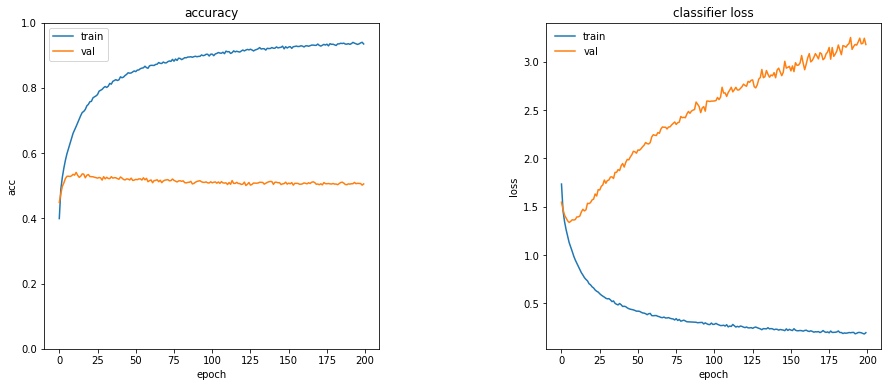

In [46]:
#%tensorboard --logdir logs/
f,ax = plt.subplots(1, 2,figsize=(15,6))
ax[1].plot(history_c.history['loss'],label='train')
ax[1].plot(history_c.history['val_loss'],label='val')
ax[1].set_title('classifier loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='upper left', frameon=False)

ax[0].plot(history_c.history['acc'])
ax[0].plot(history_c.history['val_acc'])
ax[0].set_ylim([0,1])
ax[0].set_title('accuracy')
ax[0].set_ylabel('acc')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

f.subplots_adjust(hspace=0.5)
f.subplots_adjust(wspace=0.5)

plt.show()


Classification Report:

              precision    recall  f1-score   support

    airplane       0.55      0.66      0.60      1000
  automobile       0.57      0.71      0.63      1000
        bird       0.45      0.28      0.34      1000
         cat       0.33      0.36      0.34      1000
        deer       0.49      0.31      0.38      1000
         dog       0.37      0.47      0.41      1000
        frog       0.53      0.59      0.56      1000
       horse       0.55      0.59      0.57      1000
        ship       0.64      0.66      0.65      1000
       truck       0.60      0.44      0.51      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



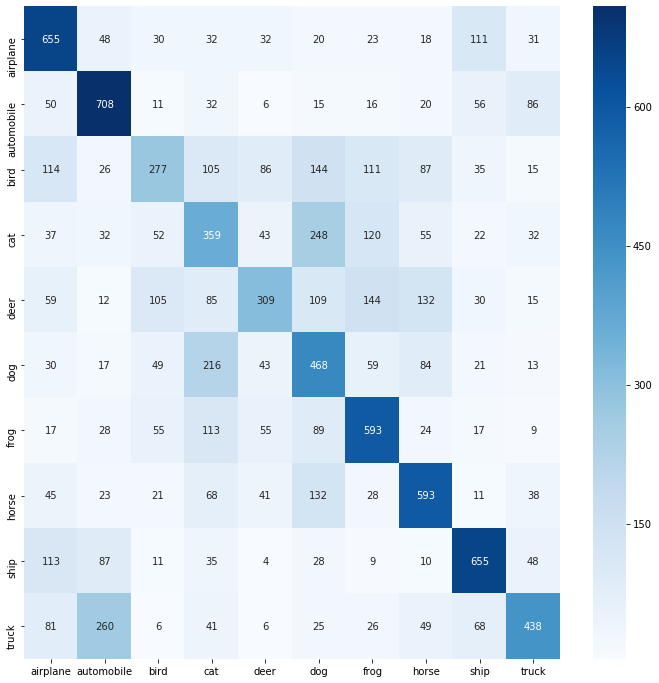

In [48]:
YpredsHot = cmodel.predict(bn_Xtest_features)
Ypreds = np.argmax(YpredsHot,axis=1)
evaluate_classification(Ytest,Ypreds)

## Convolutional Classifier 

In [89]:
def cnn_model():  
    model = Sequential()
    model.add(Conv1D(16, 2, activation='relu',padding='same',input_shape=(768,1)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Conv1D(16,2, activation='relu',padding='same'))
    #model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    return model
    

In [90]:
bn_encoder_model = Model(inputs=ae_model.input,
                                 outputs=ae_model.get_layer('bn_feats').output)

cnn_model = cnn_model()
#opt = SGD(lr=0.0007, momentum=0.9)
opt = Adam(lr = 0.001)
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        
Xtrain_features = encoder_model.predict(Xtrain)
Xtest_features = encoder_model.predict(Xtest)
bn_Xtrain_features = bn_encoder_model.predict(Xtrain)
bn_Xtest_features = bn_encoder_model.predict(Xtest)
bn_Xtrain_features_r = np.expand_dims(bn_Xtrain_features, axis=2)
bn_Xtest_features_r = np.expand_dims(bn_Xtest_features, axis=2)
print(bn_Xtrain_features_r.shape)
print(YtrainHot.shape)

history_cnn = cnn_model.fit(bn_Xtrain_features_r,
           YtrainHot,
           validation_data=(bn_Xtest_features_r, YtestHot),
           batch_size=128,
           epochs=50,
           shuffle=True)
              
# steps = int(Xtrain.shape[0] / 128)              
# history_c = cmodel.fit_generator(
#         data_generator(train_datagen,Xtrain,YtrainHot,128),
#         steps_per_epoch=steps,
#         epochs=350,
#         shuffle=True,
#         validation_data=data_generator(test_datagen,Xtest,YtestHot,128),
#         validation_steps=Xtest.shape[0]//128)


(42500, 768, 1)
(42500, 10)
Train on 42500 samples, validate on 10000 samples
Epoch 1/50
42500/42500 [==============================] - 6s 143us/sample - loss: 1.8533 - acc: 0.4285 - val_loss: 1.6917 - val_acc: 0.4379
Epoch 2/50
42500/42500 [==============================] - 4s 101us/sample - loss: 1.3075 - acc: 0.5495 - val_loss: 1.5411 - val_acc: 0.4693
Epoch 3/50
42500/42500 [==============================] - 5s 115us/sample - loss: 1.1175 - acc: 0.6159 - val_loss: 1.5642 - val_acc: 0.4698
Epoch 4/50
42500/42500 [==============================] - 4s 103us/sample - loss: 0.9566 - acc: 0.6718 - val_loss: 1.6989 - val_acc: 0.4602
Epoch 5/50
42500/42500 [==============================] - 4s 104us/sample - loss: 0.8225 - acc: 0.7154 - val_loss: 1.7942 - val_acc: 0.4569
Epoch 6/50
42500/42500 [==============================] - 5s 110us/sample - loss: 0.7169 - acc: 0.7487 - val_loss: 1.8901 - val_acc: 0.4492
Epoch 7/50
42500/42500 [==============================] - 4s 100us/sample - loss: 

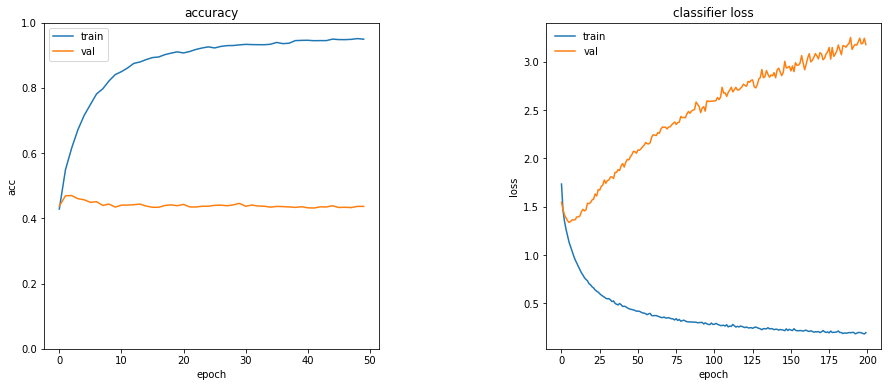

In [92]:
#%tensorboard --logdir logs/
f,ax = plt.subplots(1, 2,figsize=(15,6))
ax[1].plot(history_c.history['loss'],label='train')
ax[1].plot(history_c.history['val_loss'],label='val')
ax[1].set_title('classifier loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='upper left', frameon=False)

ax[0].plot(history_cnn.history['acc'])
ax[0].plot(history_cnn.history['val_acc'])
ax[0].set_ylim([0,1])
ax[0].set_title('accuracy')
ax[0].set_ylabel('acc')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

f.subplots_adjust(hspace=0.5)
f.subplots_adjust(wspace=0.5)

plt.show()

Classification Report:

              precision    recall  f1-score   support

    airplane       0.49      0.60      0.54      1000
  automobile       0.46      0.63      0.53      1000
        bird       0.41      0.24      0.30      1000
         cat       0.27      0.35      0.31      1000
        deer       0.45      0.24      0.32      1000
         dog       0.32      0.39      0.35      1000
        frog       0.44      0.54      0.48      1000
       horse       0.49      0.46      0.48      1000
        ship       0.57      0.62      0.59      1000
       truck       0.57      0.30      0.39      1000

    accuracy                           0.44     10000
   macro avg       0.45      0.44      0.43     10000
weighted avg       0.45      0.44      0.43     10000



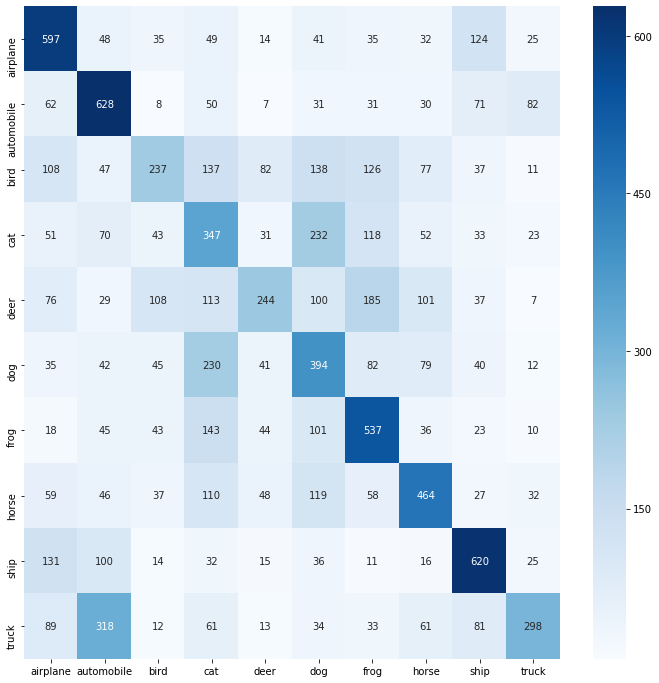

In [94]:
YpredsHot = cnn_model.predict(bn_Xtest_features_r)
Ypreds = np.argmax(YpredsHot,axis=1)
evaluate_classification(Ytest,Ypreds)